In [1]:
import plotly.plotly as py
from plotly.graph_objs import *
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot


from plyfile import PlyData, PlyElement
import numpy as np
from matplotlib import pyplot as plt


In [2]:
init_notebook_mode(connected=True)

In [3]:
%matplotlib inline


### Gather the xyz points from the ply file

In [4]:
plydata = PlyData.read('../ply/cow2.ply')

nr_points=plydata.elements[0].count
nr_faces=plydata.elements[1].count

# unpack vertices to array
vertices_pt_xyz =np.array([np.array(plydata['vertex'][k]) for k in range(nr_points)])
x,y,z=zip(*vertices_pt_xyz)

# unpack faces to array
faces_pt_3v = np.array([np.array(plydata['face'][k][0]) for k in range(nr_faces)])
faces_pt_3v[0]

array([0, 1, 2], dtype=int32)

### Plot!

In [5]:

cowScat =Scatter3d(x=x,
                y=y,
                z=z,
                mode='markers',
                marker=dict(
                    size=2,
                    color=z,                # set color to an array/list of desired values
                    colorscale='Red',   # choose a colorscale
                    opacity=0.8)
               )

xMark =Scatter3d(x=[5],
            y=[0],
            z=[0],
            mode='markers',
            marker=dict(size=15,color='rgb(255,0,0)')#'#f44242')
           )

yMark =Scatter3d(x=[0],
            y=[5],
            z=[0],
            mode='markers',
            marker=dict(size=15,color='rgb(0,255,0)')
           )

zMark =Scatter3d(x=[0],
            y=[0],
            z=[-5],
            mode='markers',
            marker=dict(size=15,color='rgb(0,0,255)')
           )

        
axis=dict(showbackground=False,
          showline=True,  
          zeroline=True,
          showgrid=True,
          showticklabels=True,
          title='' 
          )

layout = Layout(title="PLY", 
                width=800,
                height=800,
                showlegend=False,
                scene=Scene(aspectmode='manual',
                            aspectratio=dict(x=1, y=1, z=1),
                            xaxis=dict(range=[-10, 10], title='x Axis'),
                            yaxis=dict(range=[-10, 10], title='y Axis'),
                            zaxis=dict(range=[-20,0], title='z Axis'),
                            camera = dict(
                                up=dict(x=1, y=0, z=0),
                                center=dict(x=0, y=0, z=0),
                                eye=dict(x=0, y=0, z=2)
                            ),

                           ),
                margin=Margin(t=100),
                hovermode='closest',
                
                )

data=Data([cowScat,xMark,yMark,zMark])
fig=Figure(data=data, layout=layout)
iplot(fig)

### Make a projection matrix

In [6]:
fovy = 90.0 * (np.pi/180)
aspect = 1.0;
fovx = fovy * aspect;
nearDist = 0.1;
farDist = 20.0;

yScale = 1.0 / np.tan(fovy / 2);
xScale = yScale/aspect;
nearmfar = nearDist - farDist;

In [7]:
projMat_4x4 = np.zeros([4,4]);
projMat_4x4[0,0] = xScale
projMat_4x4[1,1] = yScale
projMat_4x4[2,2] = (farDist+nearDist) / (nearDist-farDist);
projMat_4x4[2,3] = -1.0;
projMat_4x4[3,2] = 2*(nearDist * farDist) / (nearDist-farDist)
projMat_4x4[3,3] = 1

projMat_4x4

array([[ 1.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  1.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        , -1.01005025, -1.        ],
       [ 0.        ,  0.        , -0.20100503,  1.        ]])

### Add the W to XYZ (homogenous coordinates)

In [8]:
homVertices_vIdx_xyzw = [np.hstack([list(plydata['vertex'][k]),1.]) for k in range(nr_points)]

In [9]:
homVertices_vIdx_xyzw[0:5]

[array([ 0.60553801,  0.18312199, -0.472278  ,  1.        ]),
 array([ 0.64922303,  0.12970001, -0.49487501,  1.        ]),
 array([ 0.60108203,  0.105512  , -0.53334302,  1.        ]),
 array([ 0.69124502,  0.0569483 , -0.52476197,  1.        ]),
 array([ 0.652035  ,  0.0379582 , -0.54233199,  1.        ])]

### Project using matrix multiplication

In [10]:
def projectVertex(xyzw,projMatIn_4x4):
    dataOutXYZW = np.matmul( projMatIn_4x4,np.transpose(xyzw))
    dataOutXYZ = dataOutXYZW[0:3] / dataOutXYZW[3]
    return dataOutXYZ
    
projVertices_vIdx_xyzw = np.apply_along_axis(projectVertex,1,homVertices_vIdx_xyzw,projMat_4x4)

In [11]:
x2,y2,z2=zip(*projVertices_vIdx_xyzw[:,0:3])

### Plot!

In [12]:

projCowScat =Scatter3d(x=x2,
                y=y2,
                z=np.tile(-10,len(x2)),#z2,
                mode='markers',
                marker=dict(
                    size=1,
                    color='#f44242',                # set color to an array/list of desired values
                    opacity=0.8)
               )
                
xMark =Scatter3d(x=[5],
            y=[0],
            z=[0],
            mode='markers',
            marker=dict(size=15,color='#f44242')
           )

yMark =Scatter3d(x=[0],
            y=[5],
            z=[0],
            mode='markers',
            marker=dict(size=15,color='#50ed7a')
           )

zMark =Scatter3d(x=[0],
            y=[0],
            z=[-5],
            mode='markers',
            marker=dict(size=15,color='#3f52e2')
           )

        
axis=dict(showbackground=False,
          showline=True,  
          zeroline=True,
          showgrid=True,
          showticklabels=True,
          title='' 
          )

layout = Layout(title="PLY", 
                width=800,
                height=800,
                showlegend=False,
                scene=Scene(aspectmode='manual',
                            aspectratio=dict(x=1, y=1, z=1),
                            xaxis=dict(range=[-10, 10], title='x Axis'),
                            yaxis=dict(range=[-10, 10], title='y Axis'),
                            zaxis=dict(range=[-20,0], title='z Axis'),
                            camera = dict(
                                up=dict(x=1, y=0, z=0),
                                center=dict(x=0, y=0, z=0),
                                eye=dict(x=0, y=0, z=2)
                            ),

                           ),
                margin=Margin(t=100),
                hovermode='closest',
                
                )


data=Data([cowScat,projCowScat,xMark,yMark,zMark])
fig=Figure(data=data, layout=layout)
iplot(fig)


# Rasterize

In [13]:
import cv2 as cv2

In [14]:

#%matplotlib notebook
#nbagg

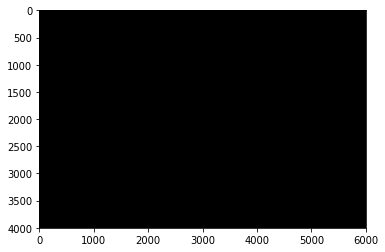

In [15]:
xmax = np.ceil(np.max(x2))
xmin = np.floor(np.min(x2))
iWidth = int(xmax-xmin)

ymax = np.ceil(np.max(y2))
ymin = np.floor(np.min(y2))
iHeight = int(ymax-ymin)

res = 1000

img = np.zeros([iHeight*res, iWidth*res, 3], dtype=np.uint8)

plt.imshow(img)

The fillPoly method did not work well, but may be faster if implemented correctly

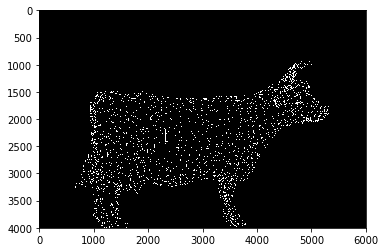

In [16]:
img = np.zeros([iHeight*res, iWidth*res, 3], dtype=np.uint8)
vertices2D_pt_xy = np.array(zip(x2,y2))

facePoints = vertices2D_pt_xy[faces_pt_3v]
facePoints = np.array(facePoints*res,dtype=np.int32)
facePoints[:,:,0] = facePoints[:,:,0] + np.round(iWidth/2)*res
facePoints[:,:,1] = np.round(iHeight)*res - facePoints[:,:,1] 

img = cv2.fillPoly(img,np.int32(facePoints),(255,255,255))
plt.imshow(img)

fillConvexPoly works!

In [17]:
img = np.zeros([iHeight*res, iWidth*res, 3], dtype=np.uint8)
vertices2D_pt_xy = np.array(zip(x2,y2))

facePoints = vertices2D_pt_xy[faces_pt_3v]
facePoints = np.array(facePoints*res,dtype=np.int32)
facePoints[:,:,0] = facePoints[:,:,0] + np.round(iWidth/2)*res
facePoints[:,:,1] = np.round(iHeight)*res - facePoints[:,:,1] 

#img = [cv2.fillConvexPoly(img,np.int32(facePoints[fIdx,:,:]),(255,255,255)) for fIdx in range((len(facePoints)))]

for fIdx in range((len(facePoints))):
    img = cv2.fillConvexPoly(img,np.int32(facePoints[fIdx,:,:]),(255,255,255))

Add a fixation point

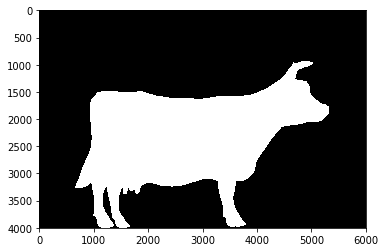

In [18]:
# ADd a fixation point    
#img = cv2.circle(img,(300,300), 100, (255,0,0), -1)

plt.imshow(img)